# Library

In [1]:
# Librerie standard
import os
import random
import time
import re
import shutil
from pathlib import Path
from collections import defaultdict, Counter
from itertools import islice
from concurrent.futures import ProcessPoolExecutor
import warnings

# Librerie per il trattamento delle immagini
import cv2
import imageio.v3 as imageio
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import patches
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Librerie per il machine learning e deep learning
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func
from torchvision.ops.boxes import box_iou
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as TF
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Librerie per la gestione dei dati
import pandas as pd
import json
import orjson
import ast

# Librerie per il progresso e il monitoraggio
from tqdm import tqdm

# Librerie per il deep learning avanzato
from torch.amp import GradScaler, autocast
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Path

In [2]:
COCO_JSON_NM = 'COCO_annotations_new.json' 
OUT_COCO_JSON_NM = 'mod_COCO_annotations_new.json'
OUT_IMAGE_FLDR_NM = 'images'
RANDOM_SEED = 2023

in_dataset_pth = Path('/kaggle/input/our-xview-dataset')
out_dataset_pth = Path('/kaggle/working/')
img_fldr = Path(f'/kaggle/input/our-xview-dataset/{OUT_IMAGE_FLDR_NM}')

coco_json_pth = in_dataset_pth / COCO_JSON_NM
new_coco_json_pth = out_dataset_pth / OUT_COCO_JSON_NM

train_path = '/kaggle/working/train.json'
test_path = '/kaggle/working/test.json'
val_path = '/kaggle/working/val.json'

random.seed(RANDOM_SEED)

In [3]:
# Pulizia dell'output per cartelle specifiche
def clean_output(output_dir):
    if output_dir.exists() and output_dir.is_dir():
        for item in output_dir.iterdir():
            if item.is_dir():
                shutil.rmtree(item)  # Rimuove la sotto-cartella
            else:
                item.unlink()  # Rimuove il file
        print(f"Cartella {output_dir} pulita.")
    else:
        print(f"Cartella {output_dir} non trovata. Nessuna azione necessaria.")

# Pulisce la cartella di output prima di avviare il processo
clean_output(out_dataset_pth)

Cartella /kaggle/working pulita.


In [4]:
# Sopprime i warning specifici del modulo skimage
warnings.filterwarnings("ignore", 
    message="Applying `local_binary_pattern` to floating-point images may give unexpected results.*")

# Background Labels

In [5]:
def process_custom_coco_json(input_path, output_path):
    """
    Funzione per processare un JSON COCO in formato personalizzato.
    """
    # Leggi il JSON dal file di input
    with open(input_path, 'r') as f:
        data = json.load(f)

    # Ottieni e correggi il formato delle categorie
    raw_categories = data.get('categories', [])
    categories = []

    for category in tqdm(raw_categories, desc="Processing Categories"):
        for id_str, name in category.items():
            try:
                categories.append({"id": int(id_str), "name": name})
            except ValueError:
                print(f"Errore nel parsing della categoria: {category}")

    # Trova la categoria "Aircraft" con ID 0
    aircraft_category = next((cat for cat in categories if cat['id'] == 0 and cat['name'] == "Aircraft"), None)
    if aircraft_category:
        aircraft_category['id'] = 11  # Cambia l'ID della categoria "Aircraft" a 11

    # Aggiungi la categoria "background" con ID 0 se non esiste
    if not any(cat['id'] == 0 for cat in categories):
        categories.append({"id": 0, "name": "background"})

    # Preprocessa le annotazioni in un dizionario per immagini
    image_annotations_dict = {}
    for annotation in tqdm(data.get('annotations', []), desc="Building Image Annotations Dictionary"):
        image_id = annotation['image_id']
        if image_id not in image_annotations_dict:
            image_annotations_dict[image_id] = []
        image_annotations_dict[image_id].append(annotation)

    # Lista di nuove annotazioni da aggiungere per immagini senza bbox
    new_annotations = []

    # Elenco di annotazioni da rimuovere
    annotations_to_remove = []

    for annotation in tqdm(data.get('annotations', []), desc="Processing Annotations"):
        if annotation['category_id'] == 0:  # Se è Aircraft
            annotation['category_id'] = 11
        
        # Converte il formato del bbox
        if isinstance(annotation['bbox'], str):
            annotation['bbox'] = json.loads(annotation['bbox'])
        
        x, y, width, height = annotation['bbox']
        xmin = x
        xmax = x + width
        ymin = y
        ymax = y + height
        
        # Verifica che xmin < xmax e ymin < ymax
        if xmin >= xmax or ymin >= ymax:
            annotations_to_remove.append(annotation['id'])
        else:
            annotation['bbox'] = [xmin, xmax, ymin, ymax]

    # Rimuovi le annotazioni non valide
    data['annotations'] = [ann for ann in data['annotations'] if ann['id'] not in annotations_to_remove]

    # Verifica se ci sono immagini senza annotazioni (usando il dizionario delle annotazioni)
    for image in tqdm(data.get('images', []), desc="Processing Images"):
        if image['id'] not in image_annotations_dict:  # Se l'immagine non ha annotazioni
            # Aggiungi la categoria "background"
            new_annotation = {
                'id': len(data['annotations']) + len(new_annotations),
                'image_id': image['id'],
                'category_id': 0,  # Categoria background con ID 0
                'area': image['width'] * image['height'],
                'bbox': [0.0, image['width'], 0.0, image['height']],  # Background con bbox che copre tutta l'immagine
                'iscrowd': 0
            }
            new_annotations.append(new_annotation)

    # Aggiungi le nuove annotazioni al JSON originale
    data['annotations'].extend(new_annotations)

    # Aggiorna le categorie nel JSON
    data['categories'] = categories

    # Scrivi il JSON modificato nel file di output
    with open(output_path, 'w') as f:
        json.dump(data, f, indent=4)

In [6]:
process_custom_coco_json(coco_json_pth, new_coco_json_pth)

Processing Images: 100%|██████████| 45891/45891 [00:00<00:00, 704461.81it/s]


In [7]:
def count_bboxes_per_category(json_path):
    """
    Funzione che conta il numero di bounding box per ciascuna categoria in un file JSON formato COCO.
    
    :param json_path: Percorso al file JSON.
    :return: Dizionario con i nomi delle categorie come chiavi e il conteggio dei bounding box come valori.
    """
    # Leggi il JSON dal file
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Ottieni mapping delle categorie (id -> nome)
    category_mapping = {cat['id']: cat['name'] for cat in data.get('categories', [])}
    
    # Conta i bounding box per ciascun category_id
    bbox_counts = defaultdict(int)
    for annotation in data.get('annotations', []):
        category_id = annotation['category_id']
        bbox_counts[category_id] += 1
    
    # Converti il conteggio usando i nomi delle categorie
    bbox_counts_named = {category_mapping[cat_id]: count for cat_id, count in bbox_counts.items()}

    return bbox_counts_named

In [8]:
bbox_counts = count_bboxes_per_category(new_coco_json_pth)

# Stampa i risultati
for category, count in bbox_counts.items():
    print(f"Categoria: {category}, Numero di bbox: {count}")

Categoria: Passenger Vehicle, Numero di bbox: 224911
Categoria: Building, Numero di bbox: 384929
Categoria: Truck, Numero di bbox: 34345
Categoria: Engineering Vehicle, Numero di bbox: 5477
Categoria: Shipping Container, Numero di bbox: 5388
Categoria: Maritime Vessel, Numero di bbox: 6329
Categoria: Railway Vehicle, Numero di bbox: 4233
Categoria: Storage Tank, Numero di bbox: 2033
Categoria: Aircraft, Numero di bbox: 1708
Categoria: Pylon, Numero di bbox: 470
Categoria: Helipad, Numero di bbox: 152
Categoria: background, Numero di bbox: 13691


# Splitting

In [9]:
def filter_invalid_boxes(annotations):
    """Filtra le annotazioni con bounding box non validi."""
    valid_annotations = []
    for annotation in annotations:
        # Estrai le coordinate del bounding box
        bbox = annotation['bbox']
        if isinstance(bbox, str):
            try:
                # Tenta di convertire la stringa in una lista
                bbox = json.loads(bbox)
            except json.JSONDecodeError:
                raise ValueError(f"Bounding box non valido: {bbox} (conversione da stringa fallita).")

        # Verifica se il bounding box ha coordinate valide
        if len(bbox) == 4:
            x_min, y_min, width, height = bbox
            if width > 0 and height > 0:
                # Converti in formato [x_min, x_max, y_min, y_max]
                annotation['bbox'] = [x_min, x_min + width, y_min, y_min + height]
                valid_annotations.append(annotation)

    return valid_annotations


def split(json_file, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    # Carica il JSON
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # Filtra le annotazioni con bounding box non validi
    valid_annotations = filter_invalid_boxes(data['annotations'])
    
    # Ottieni la lista delle immagini
    images = data['images']
    
    # Mescola casualmente gli ID delle immagini
    random.shuffle(images)
    
    # Calcola i limiti per train, validation e test
    total_images = len(images)
    total_annotations = len(valid_annotations)
    train_end = int(total_images * train_ratio)
    val_end = int(total_images * (train_ratio + val_ratio))
    
    # Suddividi le immagini nei rispettivi set
    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]
    
    # Raggruppa gli ID delle immagini per i rispettivi set
    train_image_ids = {image['id'] for image in train_images}
    val_image_ids = {image['id'] for image in val_images}
    test_image_ids = {image['id'] for image in test_images}
    
    # Filtra le annotazioni per i rispettivi set di immagini
    train_annotations = [ann for ann in valid_annotations if ann['image_id'] in train_image_ids]
    val_annotations = [ann for ann in valid_annotations if ann['image_id'] in val_image_ids]
    test_annotations = [ann for ann in valid_annotations if ann['image_id'] in test_image_ids]
    
    # Crea i nuovi JSON per train, validation e test
    train_data = {'images': train_images, 'annotations': train_annotations, 'categories': data['categories']}
    val_data = {'images': val_images, 'annotations': val_annotations, 'categories': data['categories']}
    test_data = {'images': test_images, 'annotations': test_annotations, 'categories': data['categories']}
    
    # Salva i file JSON
    with open('train.json', 'w') as f:
        json.dump(train_data, f, indent=4)
    
    with open('val.json', 'w') as f:
        json.dump(val_data, f, indent=4)
    
    with open('test.json', 'w') as f:
        json.dump(test_data, f, indent=4)
    
    # Controlla la proporzione delle immagini e delle annotazioni
    check_split_proportions(total_images, total_annotations, 
                            len(train_images), len(val_images), len(test_images), 
                            len(train_annotations), len(val_annotations), len(test_annotations), 
                            train_ratio, val_ratio, test_ratio, 
                            train_annotations, val_annotations, test_annotations, data['categories'])


def check_split_proportions(total_images, total_annotations, train_count, val_count, test_count, 
                            train_bbox_count, val_bbox_count, test_bbox_count, 
                            train_ratio, val_ratio, test_ratio, 
                            train_annotations, val_annotations, test_annotations, categories):
    # Percentuali per immagini
    train_image_percentage = (train_count / total_images) * 100
    val_image_percentage = (val_count / total_images) * 100
    test_image_percentage = (test_count / total_images) * 100
    
    # Percentuali per bbox
    train_bbox_percentage = (train_bbox_count / total_annotations) * 100
    val_bbox_percentage = (val_bbox_count / total_annotations) * 100
    test_bbox_percentage = (test_bbox_count / total_annotations) * 100
    
    print(f"Totale immagini: {total_images}")
    print(f"Totale annotazioni (bbox): {total_annotations}")
    print(f"Train: {train_count} immagini ({train_image_percentage:.2f}%) ({train_bbox_count} bbox) ({train_bbox_percentage:.2f}%)")
    print(f"Val: {val_count} immagini ({val_image_percentage:.2f}%) ({val_bbox_count} bbox) ({val_bbox_percentage:.2f}%)")
    print(f"Test: {test_count} immagini ({test_image_percentage:.2f}%) ({test_bbox_count} bbox) ({test_bbox_percentage:.2f}%)")
    
    # Calcola il numero di annotazioni per categoria nei vari set
    category_count_train = defaultdict(int)
    category_count_val = defaultdict(int)
    category_count_test = defaultdict(int)
    
    for annotation in train_annotations:
        category_count_train[annotation['category_id']] += 1
    for annotation in val_annotations:
        category_count_val[annotation['category_id']] += 1
    for annotation in test_annotations:
        category_count_test[annotation['category_id']] += 1
    
    # Stampa le proporzioni per categoria
    print("\nProporzioni per categoria:")
    for category_dict in categories:
        for category_id, category_name in category_dict.items():
            # Converti category_id in intero se necessario
            category_id = int(category_id)
            
            # Conta il numero di annotazioni per categoria in ogni set
            train_cat_count = category_count_train.get(category_id, 0)
            val_cat_count = category_count_val.get(category_id, 0)
            test_cat_count = category_count_test.get(category_id, 0)
            
            # Calcola la percentuale di annotazioni per categoria
            total_cat_annotations = train_cat_count + val_cat_count + test_cat_count
            if total_cat_annotations > 0:
                train_cat_percentage = (train_cat_count / total_cat_annotations) * 100
                val_cat_percentage = (val_cat_count / total_cat_annotations) * 100
                test_cat_percentage = (test_cat_count / total_cat_annotations) * 100
            else:
                train_cat_percentage = val_cat_percentage = test_cat_percentage = 0.0

            print(f"{category_name}:")
            print(f"  Train: {train_cat_count} annotazioni ({train_cat_percentage:.2f}%)")
            print(f"  Val: {val_cat_count} annotazioni ({val_cat_percentage:.2f}%)")
            print(f"  Test: {test_cat_count} annotazioni ({test_cat_percentage:.2f}%)")

In [10]:
# Chiamata della funzione
split(coco_json_pth)

Totale immagini: 45891
Totale annotazioni (bbox): 669975
Train: 36712 immagini (80.00%) (536321 bbox) (80.05%)
Val: 4589 immagini (10.00%) (65979 bbox) (9.85%)
Test: 4590 immagini (10.00%) (69369 bbox) (10.35%)

Proporzioni per categoria:
Aircraft:
  Train: 1394 annotazioni (81.62%)
  Val: 169 annotazioni (9.89%)
  Test: 145 annotazioni (8.49%)
Passenger Vehicle:
  Train: 179537 annotazioni (79.59%)
  Val: 22709 annotazioni (10.07%)
  Test: 23329 annotazioni (10.34%)
Truck:
  Train: 27831 annotazioni (80.63%)
  Val: 3337 annotazioni (9.67%)
  Test: 3351 annotazioni (9.71%)
Railway Vehicle:
  Train: 3378 annotazioni (79.80%)
  Val: 340 annotazioni (8.03%)
  Test: 515 annotazioni (12.17%)
Maritime Vessel:
  Train: 5025 annotazioni (79.30%)
  Val: 567 annotazioni (8.95%)
  Test: 745 annotazioni (11.76%)
Engineering Vehicle:
  Train: 4479 annotazioni (81.69%)
  Val: 452 annotazioni (8.24%)
  Test: 552 annotazioni (10.07%)
Building:
  Train: 308495 annotazioni (79.98%)
  Val: 37376 annotazi

# DataLoader

In [11]:
import operator
class CustomDataset(Dataset):
    def __init__(self, json_file, img_dir, aug=False):
        """
        Inizializza il dataset personalizzato.
        Args:
        - json_file: Il file JSON preprocessato contenente immagini, annotazioni e categorie.
        - img_dir: La directory contenente le immagini.
        - aug: Booleano per attivare o meno l'augmentazione.
        """
        # Carica il file JSON preprocessato
        with open(json_file, 'r') as f:
            coco_data = json.load(f)

        # Estrai informazioni su immagini, annotazioni e categorie
        self.image_info = {image['id']: image['file_name'] for image in coco_data['images']}
        self.image_annotations = {}
        self.image_bboxes = {}

        # Estrai le classi (categorie) dal file JSON
        self.classes = {}
        for category_dict in coco_data['categories']:
            for category_id, category_name in category_dict.items():
                # Converti category_id in intero se necessario
                self.classes[int(category_id)] = category_name

        for annotation in coco_data['annotations']:
            image_id = annotation['image_id']
            bbox = annotation['bbox']

            # Associa annotazioni e bounding box alle immagini
            if image_id not in self.image_annotations:
                self.image_annotations[image_id] = []
                self.image_bboxes[image_id] = []
            
            self.image_annotations[image_id].append(annotation['category_id'])
            self.image_bboxes[image_id].append(bbox)

        # Configura il percorso delle immagini e seleziona solo immagini valide
        self.img_dir = img_dir
        self.image_paths = []
        self.image_ids = []
        for image_id, file_name in self.image_info.items():
            if image_id in self.image_annotations:
                img_path = os.path.join(img_dir, file_name)
                if os.path.exists(img_path):
                    self.image_paths.append(img_path)
                    self.image_ids.append(image_id)

        # Definisci trasformazioni
        self.base_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

        self.aug_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

        self.aug = aug

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        """
        Recupera un'immagine e le sue annotazioni.
        """
        img_path = self.image_paths[index]
        img_id = self.image_ids[index]

        # Carica l'immagine
        image = Image.open(img_path).convert('RGB')
        original_width, original_height = image.size

        # Applica le trasformazioni
        if self.aug:
            image_tensor = self.aug_transform(image)
        else:
            image_tensor = self.base_transform(image)

        # Recupera le annotazioni e i bounding box
        categories = self.image_annotations[img_id]
        bboxes = self.image_bboxes[img_id]

        # Calcola il ridimensionamento
        scale_x = 224 / original_width
        scale_y = 224 / original_height

        # Ridimensiona i bounding box
        scaled_bboxes = [
            torch.tensor([
                bbox[0] * scale_x,  # x_min
                bbox[2] * scale_x,  # x_max
                bbox[1] * scale_y,  # y_min
                bbox[3] * scale_y   # y_max
            ], dtype=torch.float32)
            for bbox in bboxes
        ]

        # Costruisci il target
        target = {
            "boxes": torch.stack(scaled_bboxes),
            "labels": torch.tensor(categories, dtype=torch.int64)
        }

        return image_tensor, target

In [12]:
def collate_fn(batch):
    """
    Funzione di collation per il DataLoader, utile per il batching di immagini e annotazioni.
    La funzione restituirà un batch di immagini e un batch di target, formattato correttamente per Faster R-CNN.
    
    Args:
    - batch: lista di tuple (image, target)
    
    Returns:
    - images: batch di immagini
    - targets: lista di dizionari contenenti le annotazioni per ogni immagine
    """
    # Separa immagini e target
    images, targets = zip(*batch)

    # Converte la lista di immagini in un batch di immagini
    images = list(images)

    # Restituisci il batch
    return images, list(targets)

In [13]:
# Creazione dei dataset
train_dataset = CustomDataset(train_path, img_dir=img_fldr, aug=True)
valid_dataset = CustomDataset(val_path, img_dir=img_fldr, aug=False)  
test_dataset = CustomDataset(test_path, img_dir=img_fldr, aug=False)  

# Creazione dei DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True)
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)

## Check DataLoader

In [14]:
def validate_dataloader(dataloader):
    """
    Valida un DataLoader verificando che ogni immagine abbia un target associato
    e che nessun target sia `None` o vuoto.
    
    Args:
    - dataloader: Il DataLoader da verificare.
    
    Returns:
    - error_messages: Lista di messaggi di errore. Vuota se tutti i dati sono validi.
    """
    error_messages = []
    for batch_idx, (images, targets) in enumerate(dataloader):
        for idx, target in enumerate(targets):
            if target is None:
                error_messages.append(f"Batch {batch_idx}, Immagine {idx}: Target è None.")
            elif target["boxes"].numel() == 0 or target["labels"].numel() == 0:
                error_messages.append(
                    f"Batch {batch_idx}, Immagine {idx}: Target è vuoto o mancano 'boxes'/'labels'."
                )
    return error_messages

In [15]:
# Validazione del DataLoader di training
train_errors = validate_dataloader(train_loader)

if train_errors:
    print("Errori nel DataLoader di training:")
    for error in train_errors:
        print(error)
else:
    print("Tutti i target nel DataLoader di training sono validi.")

Tutti i target nel DataLoader di training sono validi.


In [16]:
# Validazione del DataLoader di training
val_errors = validate_dataloader(val_loader)

if val_errors:
    print("Errori nel DataLoader di validation:")
    for error in val_errors:
        print(error)
else:
    print("Tutti i target nel DataLoader di validation sono validi.")

Tutti i target nel DataLoader di validation sono validi.


In [17]:
# Validazione del DataLoader di training
test_errors = validate_dataloader(test_loader)

if test_errors:
    print("Errori nel DataLoader di test:")
    for error in test_errors:
        print(error)
else:
    print("Tutti i target nel DataLoader di test sono validi.")

Tutti i target nel DataLoader di test sono validi.


In [18]:
def count_images_and_targets(dataloader):
    """
    Conta il numero totale di immagini e target in un DataLoader.
    """
    num_images = 0
    num_targets = 0

    for images, targets in dataloader:
        # Conta le immagini nel batch
        num_images += len(images)
        
        # Conta i target per ogni immagine (numero di oggetti)
        for target in targets:
            num_targets += len(target["boxes"])  # Ogni immagine ha un numero di bounding boxes
    
    return num_images, num_targets

In [19]:
num_images_train, num_targets_train = count_images_and_targets(train_loader)

print(f"Numero totale di immagini per il train: {num_images_train}")
print(f"Numero totale di target per il train: {num_targets_train}")

Numero totale di immagini per il train: 25776
Numero totale di target per il train: 536321


In [20]:
num_images_val, num_targets_val = count_images_and_targets(val_loader)

print(f"Numero totale di immagini per il validation: {num_images_val}")
print(f"Numero totale di target per il validation: {num_targets_val}")

Numero totale di immagini per il validation: 3183
Numero totale di target per il validation: 65979


In [21]:
num_images_test, num_targets_test = count_images_and_targets(test_loader)

print(f"Numero totale di immagini per il test: {num_images_test}")
print(f"Numero totale di target per il test: {num_targets_test}")

Numero totale di immagini per il test: 3218
Numero totale di target per il test: 69369


In [22]:
print(f"Numero totale di immagini: {num_images_train + num_images_val +num_images_test}")
print(f"Numero totale di target: {num_targets_train + num_targets_val +num_targets_test}")

Numero totale di immagini: 32177
Numero totale di target: 671669


# Modello Faster R-CNN (Resnet50)

In [23]:
def compute_class_weights(dataset):
    # Conta la frequenza di ogni classe nel dataset
    class_counts = np.zeros(len(dataset.classes))  
    
    # Usa tqdm per monitorare il progresso mentre si itera sul dataset
    for _, targets in tqdm(dataset, desc="Calcolo frequenze delle classi", leave=False):
        # Controlla se targets è None
        if targets is None:
            print("ERRORE TARGET NONE")
            continue
        
        # Assicurati che 'labels' sia un array e itera su di esso
        if 'labels' in targets:
            for target in targets['labels']:  
                class_counts[target] += 1

    # Calcola i pesi per le classi 
    total_count = sum(class_counts)  

    # Calcola i pesi inversamente proporzionali alla frequenza
    class_weights = np.divide(total_count, class_counts)

    return class_weights

In [24]:
def calculate_map(preds, targets, num_classes, thresholds=(0.4, 0.5, 0.6), areas=(32, 96)):
    def compute_iou(box1, box2):
        """Calcola l'IoU tra due bounding boxes."""
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])

        inter_area = max(0, x2 - x1) * max(0, y2 - y1)
        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union_area = box1_area + box2_area - inter_area

        return inter_area / union_area if union_area > 0 else 0

    def get_adaptive_threshold(area, thresholds, areas):
        """Determina la soglia di IoU adattiva in base all'area dell'oggetto."""
        small_threshold, medium_threshold, large_threshold = thresholds
        small_area, medium_area = areas

        if area < small_area:
            return small_threshold
        elif area < medium_area:
            return medium_threshold
        else:
            return large_threshold

    aps = []  # Average Precision per classe

    # Aggiungi tqdm per monitorare il ciclo per classe
    for cls in tqdm(range(num_classes), desc="Calcolando mAP per le classi"):
        cls_gt_boxes = []
        cls_pred_boxes = []
        cls_scores = []

        # Estrai bounding box e predizioni per la classe corrente
        for i in range(len(targets)):
            # Ground truth
            gt_boxes = targets[i]["boxes"]
            gt_labels = targets[i]["labels"]
            cls_gt_boxes.extend([gt_boxes[j] for j in range(len(gt_labels)) if gt_labels[j] == cls])

            # Predizioni
            pred_boxes = preds[i]["boxes"]
            pred_scores = preds[i]["scores"]
            pred_labels = preds[i]["labels"]
            for j in range(len(pred_labels)):
                if pred_labels[j] == cls:
                    cls_pred_boxes.append(pred_boxes[j])
                    cls_scores.append(pred_scores[j])

        # Ordina le predizioni per confidence score decrescente (utilizzando np.argsort per efficienza)
        sorted_idx = np.argsort(cls_scores)[::-1]
        cls_pred_boxes = np.array(cls_pred_boxes)[sorted_idx]
        cls_scores = np.array(cls_scores)[sorted_idx]

        tp = np.zeros(len(cls_pred_boxes))
        fp = np.zeros(len(cls_pred_boxes))
        gt_used = np.zeros(len(cls_gt_boxes))

        # Aggiungi tqdm per monitorare il ciclo per ogni predizione
        for j, pred in enumerate(cls_pred_boxes):
            best_iou = 0
            best_gt_idx = -1

            for k, gt_box in enumerate(cls_gt_boxes):
                iou = compute_iou(pred, gt_box)
                area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
                adaptive_threshold = get_adaptive_threshold(area, thresholds, areas)

                if iou > best_iou and iou >= adaptive_threshold and not gt_used[k]:
                    best_iou = iou
                    best_gt_idx = k

            if best_gt_idx >= 0:
                tp[j] = 1
                gt_used[best_gt_idx] = 1
            else:
                fp[j] = 1

        # Calcola Precision e Recall
        cum_tp = np.cumsum(tp)
        cum_fp = np.cumsum(fp)
        precision = cum_tp / (cum_tp + cum_fp + 1e-6)
        recall = cum_tp / len(cls_gt_boxes) if len(cls_gt_boxes) > 0 else np.zeros_like(cum_tp)

        # Interpolazione per l'AP
        ap = 0
        for t in np.linspace(0, 1, 101):
            precisions = precision[recall >= t]
            ap += max(precisions) if len(precisions) > 0 else 0
        ap /= 101

        aps.append(ap)

    return np.mean(aps)

In [25]:
def train_and_validate(model, train_loader, val_loader, optimizer, device, class_weights=None, 
                       num_epochs=10, num_classes=12, accumulation_steps=4):
    """
    Funzione di training e validazione per Faster R-CNN, con valutazione basata su Precision e Recall.
    """
    # Scaler per mixed precision training
    scaler = GradScaler()
    model.to(device)

    train_losses = []
    val_losses = []
    train_precision = []
    val_precision = []
    train_recall = []
    val_recall = []

    # Converte class_weights in tensor e sposta sul dispositivo
    if class_weights is not None:
        class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    for epoch in range(num_epochs):
        print(f"\nEpoca {epoch + 1}/{num_epochs}")

        # --------------------
        # Training
        # --------------------
        model.train()
        total_train_loss = 0.0
        train_loop = tqdm(train_loader, desc="Training", leave=False)

        for i, (images, targets) in enumerate(train_loop):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
            with autocast('cuda'):
                # Forward pass
                loss_output = model(images, targets)
                
                # Controlla se `loss_output` è una lista e convertila in un dizionario
                if isinstance(loss_output, list):
                    loss_dict = {f'loss_{idx}': loss for idx, loss in enumerate(loss_output)}
                elif isinstance(loss_output, dict):
                    loss_dict = loss_output
                else:
                    raise ValueError(f"Formato di loss_output non supportato: {type(loss_output)}")
            
                total_weighted_loss = 0
                total_weight = 0
            
                # Itera su tutte le perdite
                for key, loss in loss_dict.items():
                    if isinstance(loss, torch.Tensor):
                        if key == 'loss_classifier' and class_weights is not None:
                            # Applica i pesi delle classi solo alla loss_classifier
                            labels = torch.cat([t['labels'] for t in targets])  # Ottieni le etichette
                            weighted_loss = loss * class_weights[labels]  # Pesi basati sulle etichette
                            total_weighted_loss += weighted_loss.sum()  # Somma la perdita pesata
                            total_weight += class_weights[labels].sum()  # Somma i pesi per il calcolo totale
                        else:
                            # Entra qui per loss_box_reg, loss_objectness e loss_rpn_box_reg
                            total_weighted_loss += loss.sum()  # Somma la perdita normale
                            total_weight += loss.numel()  # Somma il numero di elementi
            
                # Controlla che `total_weight` non sia zero prima della divisione
                if total_weight > 0:
                    losses = total_weighted_loss / total_weight  # Calcola la perdita totale normalizzata
                else:
                    losses = torch.tensor(0.0, device=device)  # Imposta una perdita di default
            
            # Backward pass con gradient scaling
            scaler.scale(losses).backward()
        
            # Gradient accumulation
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
        
            total_train_loss += losses.item() * accumulation_steps
            train_loop.set_postfix(loss=losses.item() * accumulation_steps)

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Perdita media di training: {avg_train_loss:.4f}")

        # Calcolo Precision e Recall per il training
        train_prec, train_rec = evaluate_precision_recall(model, train_loader, device, num_classes)
        train_precision.append(train_prec)
        train_recall.append(train_rec)
        print(f"Precision di training: {train_prec:.4f}, Recall di training: {train_rec:.4f}")
        
        # --------------------
        # Validazione
        # --------------------
        model.eval()
        total_val_loss = 0.0
        val_loop = tqdm(val_loader, desc="Validazione", leave=False)

        """with torch.no_grad():
            for images, targets in val_loop:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                with autocast('cuda'):
                    # Forward pass
                    loss_output = model(images, targets)
                    
                    # Controlla se `loss_output` è una lista e convertila in un dizionario
                    if isinstance(loss_output, list):
                        loss_dict = {f'loss_{idx}': loss for idx, loss in enumerate(loss_output)}
                    elif isinstance(loss_output, dict):
                        loss_dict = loss_output
                    else:
                        raise ValueError(f"Formato di loss_output non supportato: {type(loss_output)}")
        
                    total_weighted_loss = 0
                    total_weight = 0
                    for key, loss in loss_dict.items():
                        if isinstance(loss, torch.Tensor):
                            total_weighted_loss += loss.sum()
                            total_weight += loss.numel()
        
                    # Controlla che `total_weight` non sia zero prima della divisione
                    if total_weight > 0:
                        losses = total_weighted_loss / total_weight
                    else:
                        losses = torch.tensor(0.0, device=device)  # Imposta una perdita di default
        
                total_val_loss += losses.item()"""

        with torch.no_grad():
            for images, targets in val_loop:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
                with autocast('cuda'):
                    # Forward pass
                    try:
                        loss_output = model(images, targets)
        
                        # Controlla se `loss_output` è una lista o un dizionario
                        if isinstance(loss_output, list):
                            loss_dict = {f'loss_{idx}': loss for idx, loss in enumerate(loss_output)}
                        elif isinstance(loss_output, dict):
                            loss_dict = loss_output
                        else:
                            raise ValueError(f"Formato di loss_output non supportato: {type(loss_output)}")
        
                        # Calcolo delle perdite totali
                        total_weighted_loss = 0
                        total_weight = 0
                        for key, loss in loss_dict.items():
                            if isinstance(loss, torch.Tensor) and loss.numel() > 0:  # Controllo aggiuntivo
                                total_weighted_loss += loss.sum()
                                total_weight += loss.numel() # per la gestione della loss nulla
        
                        # Controlla che `total_weight` non sia zero prima della divisione
                        if total_weight > 0:
                            losses = total_weighted_loss / total_weight
                        else:
                            losses = torch.tensor(0.0, device=device)  # Imposta una perdita di default
                            print(f"Warning: Total weight is zero. Loss set to {losses.item()}")
        
                    except Exception as e:
                        print(f"Errore durante il calcolo della loss: {e}")
                        losses = torch.tensor(0.0, device=device)  # Imposta una perdita di default
        
                total_val_loss += losses.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Perdita media di validazione: {avg_val_loss:.4f}")

        # Calcolo Precision e Recall per la validazione
        val_prec, val_rec = evaluate_precision_recall(model, val_loader, device, num_classes)
        val_precision.append(val_prec)
        val_recall.append(val_rec)
        print(f"Precision di validazione: {val_prec:.4f}, Recall di validazione: {val_rec:.4f}")

        # --------------------
        # Salvataggio del modello
        # --------------------
        torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")
        print(f"Modello salvato: model_epoch_{epoch + 1}.pth")

    return train_losses, val_losses, train_precision, val_precision, train_recall, val_recall


In [26]:
def plot_metrics(train_losses, val_losses, train_precision, val_precision, train_recall, val_recall, num_epochs):
    """
    Funzione per plottare le metriche di training e validazione (Loss e mAP).
    """
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 8))

    # Plot della Loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss per Epoca')

    # Plot della precision
    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, train_precision, label='Training precision', color='green')
    plt.plot(epochs_range, val_precision, label='Validation precision', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.title('Precision per Epoca')

    # Plot della recall
    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, train_recall, label='Training recall', color='green')
    plt.plot(epochs_range, val_recall, label='Validation recall', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.title('Recall per Epoca')

    plt.tight_layout()
    plt.show()

In [52]:
def visualize_predictions(image, boxes, labels, scores, class_names, threshold=0.5):
    """
    Visualizza le predizioni (bounding boxes e etichette) su una singola immagine.
    """
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    # Filtra predizioni con punteggio sopra la soglia
    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            # Rettangolo per la bounding box
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                      linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Etichetta con classe e punteggio
            ax.text(box[0], box[1] - 10, f'{class_names[label]}: {score:.2f}', color='r',
                    fontsize=12, fontweight='bold', backgroundcolor='white')

    plt.show()

def plot_confusion_matrix(all_preds, all_targets, class_names, score_threshold=0.5):
    """
    Calcola e visualizza la confusion matrix.
    """
    pred_labels = []
    true_labels = []

    for pred, target in zip(all_preds, all_targets):
        # Filtra le predizioni in base al punteggio
        valid_indices = pred['scores'] >= score_threshold
        filtered_pred_labels = pred['labels'][valid_indices].cpu().numpy()

        # Aggiungi tutte le etichette previste e reali
        pred_labels.extend(filtered_pred_labels)
        true_labels.extend(target['labels'].cpu().numpy())

    # Assicurati che il numero di previsioni e target sia coerente
    if len(pred_labels) != len(true_labels):
        min_len = min(len(pred_labels), len(true_labels))
        pred_labels = pred_labels[:min_len]
        true_labels = true_labels[:min_len]

    # Calcola la matrice di confusione
    cm = confusion_matrix(true_labels, pred_labels, labels=range(len(class_names)))

    # Visualizza la matrice di confusione
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap="Blues", values_format='d')
    plt.title("Confusion Matrix")
    plt.show()
    
def test_model(model, test_loader, device, class_names, num_classes=12, num_visualizations=5):
    """
    Funzione per il testing del modello Faster R-CNN.
    """
    model.to(device)
    model.eval()
    predictions = []
    all_preds = []  # Per calcolo mAP
    all_targets = []  # Per calcolo mAP

    print("\nInizio testing...")
    test_loop = tqdm(test_loader, desc="Testing", leave=False)
    visualized = 0  # Contatore per visualizzazioni

    with torch.no_grad():
        for images, targets in test_loop:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Targets su dispositivo

            # Predizioni dal modello
            preds = model(images)

            for pred, target in zip(preds, targets):
                predictions.append({
                    'boxes': pred['boxes'].cpu().numpy(),
                    'labels': pred['labels'].cpu().numpy(),
                    'scores': pred['scores'].cpu().numpy()
                })

                # Raccogli predizioni e target per calcolo mAP
                all_preds.append(pred)
                all_targets.append(target)

                # Visualizza immagini con bounding box
                if visualized < num_visualizations:
                    visualize_predictions(
                        images[0].cpu().numpy().transpose(1, 2, 0),  # Converti (C, H, W) -> (H, W, C)
                        pred['boxes'].cpu().numpy(),
                        pred['labels'].cpu().numpy(),
                        pred['scores'].cpu().numpy(),
                        class_names
                    )
                    visualized += 1

            # Aggiorna barra di avanzamento
            test_loop.set_postfix(processed=len(predictions))

    # Calcola e visualizza statistiche globali
    total_preds = sum(len(pred['labels']) for pred in all_preds)
    total_targets = sum(len(target['labels']) for target in all_targets)
    average_preds_per_image = total_preds / len(all_preds) if all_preds else 0
    average_targets_per_image = total_targets / len(all_targets) if all_targets else 0

    print("\nStatistiche globali del test set:")
    print(f"Numero totale di immagini processate: {len(all_preds)}")
    print(f"Numero totale di oggetti predetti: {total_preds}")
    print(f"Numero totale di oggetti target: {total_targets}")
    print(f"Numero medio di predizioni per immagine: {average_preds_per_image:.2f}")
    print(f"Numero medio di oggetti target per immagine: {average_targets_per_image:.2f}")

    # Visualizza la confusion matrix
    plot_confusion_matrix(all_preds, all_targets, class_names)

    print("Testing completato.")
    return predictions


def evaluate_precision_recall(model, data_loader, device, num_classes, iou_threshold=0.5, score_threshold=0.5):
    """
    Calcola Precision e Recall basati su IoU per Faster R-CNN.
    """
    model.eval()
    true_positives = [0] * num_classes
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating", leave=False):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Predizioni
            outputs = model(images)

            for target, output in zip(targets, outputs):
                target_boxes = target['boxes'].cpu()
                target_labels = target['labels'].cpu()
                pred_boxes = output['boxes'].cpu()
                pred_labels = output['labels'].cpu()
                pred_scores = output['scores'].cpu()

                # Filtra predizioni con punteggio basso
                high_score_indices = pred_scores > score_threshold
                pred_boxes = pred_boxes[high_score_indices]
                pred_labels = pred_labels[high_score_indices]

                # Confronta predizioni e target
                if len(pred_boxes) > 0 and len(target_boxes) > 0:
                    ious = box_iou(pred_boxes, target_boxes)  # IoU
                    for pred_idx, pred_label in enumerate(pred_labels):
                        iou_values = ious[pred_idx]
                        max_iou_idx = torch.argmax(iou_values)
                        max_iou = iou_values[max_iou_idx]

                        if max_iou >= iou_threshold and pred_label == target_labels[max_iou_idx]:
                            true_positives[pred_label] += 1
                            ious[:, max_iou_idx] = 0  # Disabilita target già usati
                        else:
                            false_positives[pred_label] += 1

                # False negatives
                for target_label in target_labels:
                    if target_label not in pred_labels:
                        false_negatives[target_label] += 1

    # Precision e Recall
    precision = sum(true_positives) / (sum(true_positives) + sum(false_positives) + 1e-6)
    recall = sum(true_positives) / (sum(true_positives) + sum(false_negatives) + 1e-6)

    return precision, recall


In [28]:
# Carica il modello Faster R-CNN con ResNet50 e FPN
model = fasterrcnn_resnet50_fpn(weights=None)

num_classes = 12

# Modifica il numero di classi in output
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Congela i layer della backbone (ResNet50)
for param in model.backbone.parameters():
    param.requires_grad = False

# Imposta il dispositivo (GPU o CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configurazione training
num_epochs = 2
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Sposta il modello su GPU o CPU
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [29]:
# Calcola i pesi delle classi
class_weights = compute_class_weights(train_loader.dataset)

print(class_weights)

[3.84735294e+02 2.98724497e+00 1.92706335e+01 1.58768798e+02
 1.06730547e+02 1.19741237e+02 1.73850792e+00 4.58394017e+03
 3.46460594e+02 1.29828371e+02 1.38943264e+03]


In [30]:
train_losses, val_losses, train_precision, val_precision, train_recall, val_recall = train_and_validate(model, train_loader, val_loader, optimizer, device, class_weights, num_epochs)


Epoca 1/2


Perdita media di training: 1.6827


Precision di training: 0.2655, Recall di training: 0.5250


Validazione:   1%|          | 1/100 [00:02<03:29,  2.12s/it]

Validazione:   2%|▏         | 2/100 [00:03<03:03,  1.87s/it]

Validazione:   3%|▎         | 3/100 [00:05<02:53,  1.78s/it]

Validazione:   4%|▍         | 4/100 [00:07<02:48,  1.75s/it]

Validazione:   5%|▌         | 5/100 [00:08<02:43,  1.72s/it]

Validazione:   6%|▌         | 6/100 [00:10<02:41,  1.72s/it]

Validazione:   7%|▋         | 7/100 [00:12<02:39,  1.72s/it]

Validazione:   8%|▊         | 8/100 [00:13<02:36,  1.70s/it]

Validazione:   9%|▉         | 9/100 [00:15<02:34,  1.70s/it]

Validazione:  10%|█         | 10/100 [00:17<02:32,  1.70s/it]

Validazione:  11%|█         | 11/100 [00:19<02:31,  1.70s/it]

Validazione:  12%|█▏        | 12/100 [00:20<02:28,  1.69s/it]

Validazione:  13%|█▎        | 13/100 [00:22<02:27,  1.69s/it]

Validazione:  14%|█▍        | 14/100 [00:24<02:25,  1.69s/it]

Validazione:  15%|█▌        | 15/100 [00:25<02:23,  1.69s/it]

Validazione:  16%|█▌        | 16/100 [00:27<02:21,  1.69s/it]

Validazione:  17%|█▋        | 17/100 [00:29<02:20,  1.69s/it]

Validazione:  18%|█▊        | 18/100 [00:30<02:18,  1.69s/it]

Validazione:  19%|█▉        | 19/100 [00:32<02:17,  1.69s/it]

Validazione:  20%|██        | 20/100 [00:34<02:15,  1.69s/it]

Validazione:  21%|██        | 21/100 [00:35<02:13,  1.69s/it]

Validazione:  22%|██▏       | 22/100 [00:37<02:11,  1.69s/it]

Validazione:  23%|██▎       | 23/100 [00:39<02:09,  1.69s/it]

Validazione:  24%|██▍       | 24/100 [00:40<02:08,  1.69s/it]

Validazione:  25%|██▌       | 25/100 [00:42<02:06,  1.69s/it]

Validazione:  26%|██▌       | 26/100 [00:44<02:04,  1.69s/it]

Validazione:  27%|██▋       | 27/100 [00:46<02:03,  1.69s/it]

Validazione:  28%|██▊       | 28/100 [00:47<02:01,  1.69s/it]

Validazione:  29%|██▉       | 29/100 [00:49<02:00,  1.69s/it]

Validazione:  30%|███       | 30/100 [00:51<01:58,  1.69s/it]

Validazione:  31%|███       | 31/100 [00:52<01:56,  1.69s/it]

Validazione:  32%|███▏      | 32/100 [00:54<01:54,  1.69s/it]

Validazione:  33%|███▎      | 33/100 [00:56<01:52,  1.69s/it]

Validazione:  34%|███▍      | 34/100 [00:57<01:51,  1.69s/it]

Validazione:  35%|███▌      | 35/100 [00:59<01:49,  1.69s/it]

Validazione:  36%|███▌      | 36/100 [01:01<01:47,  1.69s/it]

Validazione:  37%|███▋      | 37/100 [01:02<01:46,  1.68s/it]

Validazione:  38%|███▊      | 38/100 [01:04<01:44,  1.69s/it]

Validazione:  39%|███▉      | 39/100 [01:06<01:43,  1.69s/it]

Validazione:  40%|████      | 40/100 [01:08<01:41,  1.69s/it]

Validazione:  41%|████      | 41/100 [01:09<01:39,  1.69s/it]

Validazione:  42%|████▏     | 42/100 [01:11<01:38,  1.69s/it]

Validazione:  43%|████▎     | 43/100 [01:13<01:36,  1.69s/it]

Validazione:  44%|████▍     | 44/100 [01:14<01:34,  1.69s/it]

Validazione:  45%|████▌     | 45/100 [01:16<01:32,  1.69s/it]

Validazione:  46%|████▌     | 46/100 [01:18<01:30,  1.68s/it]

Validazione:  47%|████▋     | 47/100 [01:19<01:29,  1.69s/it]

Validazione:  48%|████▊     | 48/100 [01:21<01:27,  1.68s/it]

Validazione:  49%|████▉     | 49/100 [01:23<01:25,  1.68s/it]

Validazione:  50%|█████     | 50/100 [01:24<01:24,  1.68s/it]

Validazione:  51%|█████     | 51/100 [01:26<01:22,  1.69s/it]

Validazione:  52%|█████▏    | 52/100 [01:28<01:20,  1.69s/it]

Validazione:  53%|█████▎    | 53/100 [01:29<01:19,  1.69s/it]

Validazione:  54%|█████▍    | 54/100 [01:31<01:17,  1.69s/it]

Validazione:  55%|█████▌    | 55/100 [01:33<01:15,  1.69s/it]

Validazione:  56%|█████▌    | 56/100 [01:34<01:14,  1.69s/it]

Validazione:  57%|█████▋    | 57/100 [01:36<01:12,  1.69s/it]

Validazione:  58%|█████▊    | 58/100 [01:38<01:10,  1.68s/it]

Validazione:  59%|█████▉    | 59/100 [01:40<01:09,  1.69s/it]

Validazione:  60%|██████    | 60/100 [01:41<01:07,  1.68s/it]

Validazione:  61%|██████    | 61/100 [01:43<01:05,  1.69s/it]

Validazione:  62%|██████▏   | 62/100 [01:45<01:04,  1.68s/it]

Validazione:  63%|██████▎   | 63/100 [01:46<01:02,  1.68s/it]

Validazione:  64%|██████▍   | 64/100 [01:48<01:00,  1.69s/it]

Validazione:  65%|██████▌   | 65/100 [01:50<00:59,  1.69s/it]

Validazione:  66%|██████▌   | 66/100 [01:51<00:57,  1.69s/it]

Validazione:  67%|██████▋   | 67/100 [01:53<00:55,  1.69s/it]

Validazione:  68%|██████▊   | 68/100 [01:55<00:54,  1.69s/it]

Validazione:  69%|██████▉   | 69/100 [01:56<00:52,  1.69s/it]

Validazione:  70%|███████   | 70/100 [01:58<00:50,  1.69s/it]

Validazione:  71%|███████   | 71/100 [02:00<00:49,  1.69s/it]

Validazione:  72%|███████▏  | 72/100 [02:01<00:47,  1.69s/it]

Validazione:  73%|███████▎  | 73/100 [02:03<00:45,  1.69s/it]

Validazione:  74%|███████▍  | 74/100 [02:05<00:43,  1.69s/it]

Validazione:  75%|███████▌  | 75/100 [02:07<00:42,  1.68s/it]

Validazione:  76%|███████▌  | 76/100 [02:08<00:40,  1.68s/it]

Validazione:  77%|███████▋  | 77/100 [02:10<00:38,  1.68s/it]

Validazione:  78%|███████▊  | 78/100 [02:12<00:37,  1.69s/it]

Validazione:  79%|███████▉  | 79/100 [02:13<00:35,  1.69s/it]

Validazione:  80%|████████  | 80/100 [02:15<00:33,  1.69s/it]

Validazione:  81%|████████  | 81/100 [02:17<00:32,  1.69s/it]

Validazione:  82%|████████▏ | 82/100 [02:18<00:30,  1.69s/it]

Validazione:  83%|████████▎ | 83/100 [02:20<00:28,  1.69s/it]

Validazione:  84%|████████▍ | 84/100 [02:22<00:27,  1.69s/it]

Validazione:  85%|████████▌ | 85/100 [02:23<00:25,  1.69s/it]

Validazione:  86%|████████▌ | 86/100 [02:25<00:23,  1.69s/it]

Validazione:  87%|████████▋ | 87/100 [02:27<00:21,  1.69s/it]

Validazione:  88%|████████▊ | 88/100 [02:28<00:20,  1.69s/it]

Validazione:  89%|████████▉ | 89/100 [02:30<00:18,  1.69s/it]

Validazione:  90%|█████████ | 90/100 [02:32<00:16,  1.69s/it]

Validazione:  91%|█████████ | 91/100 [02:34<00:15,  1.69s/it]

Validazione:  92%|█████████▏| 92/100 [02:35<00:13,  1.69s/it]

Validazione:  93%|█████████▎| 93/100 [02:37<00:11,  1.69s/it]

Validazione:  94%|█████████▍| 94/100 [02:39<00:10,  1.69s/it]

Validazione:  95%|█████████▌| 95/100 [02:40<00:08,  1.69s/it]

Validazione:  96%|█████████▌| 96/100 [02:42<00:06,  1.69s/it]

Validazione:  97%|█████████▋| 97/100 [02:44<00:05,  1.69s/it]

Validazione:  98%|█████████▊| 98/100 [02:45<00:03,  1.69s/it]

Validazione:  99%|█████████▉| 99/100 [02:47<00:01,  1.69s/it]

Perdita media di validazione: 0.0000


Precision di validazione: 0.2644, Recall di validazione: 0.5313
Modello salvato: model_epoch_1.pth

Epoca 2/2


Perdita media di training: 1.3676


Precision di training: 0.2573, Recall di training: 0.6836


Validazione:   1%|          | 1/100 [00:02<03:32,  2.14s/it]

Validazione:   2%|▏         | 2/100 [00:03<03:04,  1.88s/it]

Validazione:   3%|▎         | 3/100 [00:05<02:54,  1.80s/it]

Validazione:   4%|▍         | 4/100 [00:07<02:48,  1.75s/it]

Validazione:   5%|▌         | 5/100 [00:08<02:44,  1.73s/it]

Validazione:   6%|▌         | 6/100 [00:10<02:41,  1.72s/it]

Validazione:   7%|▋         | 7/100 [00:12<02:39,  1.71s/it]

Validazione:   8%|▊         | 8/100 [00:13<02:36,  1.70s/it]

Validazione:   9%|▉         | 9/100 [00:15<02:34,  1.70s/it]

Validazione:  10%|█         | 10/100 [00:17<02:32,  1.70s/it]

Validazione:  11%|█         | 11/100 [00:19<02:30,  1.69s/it]

Validazione:  12%|█▏        | 12/100 [00:20<02:28,  1.69s/it]

Validazione:  13%|█▎        | 13/100 [00:22<02:26,  1.69s/it]

Validazione:  14%|█▍        | 14/100 [00:24<02:25,  1.69s/it]

Validazione:  15%|█▌        | 15/100 [00:25<02:23,  1.69s/it]

Validazione:  16%|█▌        | 16/100 [00:27<02:22,  1.69s/it]

Validazione:  17%|█▋        | 17/100 [00:29<02:20,  1.69s/it]

Validazione:  18%|█▊        | 18/100 [00:30<02:18,  1.69s/it]

Validazione:  19%|█▉        | 19/100 [00:32<02:17,  1.69s/it]

Validazione:  20%|██        | 20/100 [00:34<02:15,  1.69s/it]

Validazione:  21%|██        | 21/100 [00:35<02:13,  1.69s/it]

Validazione:  22%|██▏       | 22/100 [00:37<02:12,  1.69s/it]

Validazione:  23%|██▎       | 23/100 [00:39<02:10,  1.69s/it]

Validazione:  24%|██▍       | 24/100 [00:41<02:08,  1.69s/it]

Validazione:  25%|██▌       | 25/100 [00:42<02:07,  1.69s/it]

Validazione:  26%|██▌       | 26/100 [00:44<02:05,  1.69s/it]

Validazione:  27%|██▋       | 27/100 [00:46<02:03,  1.69s/it]

Validazione:  28%|██▊       | 28/100 [00:47<02:01,  1.69s/it]

Validazione:  29%|██▉       | 29/100 [00:49<02:00,  1.69s/it]

Validazione:  30%|███       | 30/100 [00:51<01:58,  1.69s/it]

Validazione:  31%|███       | 31/100 [00:52<01:56,  1.69s/it]

Validazione:  32%|███▏      | 32/100 [00:54<01:55,  1.69s/it]

Validazione:  33%|███▎      | 33/100 [00:56<01:53,  1.69s/it]

Validazione:  34%|███▍      | 34/100 [00:57<01:51,  1.69s/it]

Validazione:  35%|███▌      | 35/100 [00:59<01:49,  1.69s/it]

Validazione:  36%|███▌      | 36/100 [01:01<01:48,  1.69s/it]

Validazione:  37%|███▋      | 37/100 [01:03<01:46,  1.69s/it]

Validazione:  38%|███▊      | 38/100 [01:04<01:44,  1.69s/it]

Validazione:  39%|███▉      | 39/100 [01:06<01:43,  1.69s/it]

Validazione:  40%|████      | 40/100 [01:08<01:41,  1.69s/it]

Validazione:  41%|████      | 41/100 [01:09<01:39,  1.69s/it]

Validazione:  42%|████▏     | 42/100 [01:11<01:38,  1.69s/it]

Validazione:  43%|████▎     | 43/100 [01:13<01:36,  1.69s/it]

Validazione:  44%|████▍     | 44/100 [01:14<01:34,  1.69s/it]

Validazione:  45%|████▌     | 45/100 [01:16<01:32,  1.69s/it]

Validazione:  46%|████▌     | 46/100 [01:18<01:31,  1.69s/it]

Validazione:  47%|████▋     | 47/100 [01:19<01:29,  1.69s/it]

Validazione:  48%|████▊     | 48/100 [01:21<01:27,  1.69s/it]

Validazione:  49%|████▉     | 49/100 [01:23<01:26,  1.69s/it]

Validazione:  50%|█████     | 50/100 [01:25<01:24,  1.69s/it]

Validazione:  51%|█████     | 51/100 [01:26<01:22,  1.69s/it]

Validazione:  52%|█████▏    | 52/100 [01:28<01:20,  1.69s/it]

Validazione:  53%|█████▎    | 53/100 [01:30<01:19,  1.69s/it]

Validazione:  54%|█████▍    | 54/100 [01:31<01:17,  1.69s/it]

Validazione:  55%|█████▌    | 55/100 [01:33<01:16,  1.69s/it]

Validazione:  56%|█████▌    | 56/100 [01:35<01:14,  1.69s/it]

Validazione:  57%|█████▋    | 57/100 [01:36<01:12,  1.69s/it]

Validazione:  58%|█████▊    | 58/100 [01:38<01:11,  1.69s/it]

Validazione:  59%|█████▉    | 59/100 [01:40<01:09,  1.69s/it]

Validazione:  60%|██████    | 60/100 [01:41<01:07,  1.69s/it]

Validazione:  61%|██████    | 61/100 [01:43<01:05,  1.69s/it]

Validazione:  62%|██████▏   | 62/100 [01:45<01:04,  1.69s/it]

Validazione:  63%|██████▎   | 63/100 [01:47<01:02,  1.69s/it]

Validazione:  64%|██████▍   | 64/100 [01:48<01:00,  1.69s/it]

Validazione:  65%|██████▌   | 65/100 [01:50<00:59,  1.69s/it]

Validazione:  66%|██████▌   | 66/100 [01:52<00:57,  1.69s/it]

Validazione:  67%|██████▋   | 67/100 [01:53<00:55,  1.69s/it]

Validazione:  68%|██████▊   | 68/100 [01:55<00:54,  1.69s/it]

Validazione:  69%|██████▉   | 69/100 [01:57<00:52,  1.69s/it]

Validazione:  70%|███████   | 70/100 [01:58<00:50,  1.69s/it]

Validazione:  71%|███████   | 71/100 [02:00<00:48,  1.69s/it]

Validazione:  72%|███████▏  | 72/100 [02:02<00:47,  1.69s/it]

Validazione:  73%|███████▎  | 73/100 [02:03<00:45,  1.69s/it]

Validazione:  74%|███████▍  | 74/100 [02:05<00:43,  1.69s/it]

Validazione:  75%|███████▌  | 75/100 [02:07<00:42,  1.69s/it]

Validazione:  76%|███████▌  | 76/100 [02:08<00:40,  1.69s/it]

Validazione:  77%|███████▋  | 77/100 [02:10<00:38,  1.69s/it]

Validazione:  78%|███████▊  | 78/100 [02:12<00:37,  1.69s/it]

Validazione:  79%|███████▉  | 79/100 [02:14<00:35,  1.69s/it]

Validazione:  80%|████████  | 80/100 [02:15<00:33,  1.69s/it]

Validazione:  81%|████████  | 81/100 [02:17<00:32,  1.70s/it]

Validazione:  82%|████████▏ | 82/100 [02:19<00:30,  1.70s/it]

Validazione:  83%|████████▎ | 83/100 [02:20<00:28,  1.70s/it]

Validazione:  84%|████████▍ | 84/100 [02:22<00:27,  1.70s/it]

Validazione:  85%|████████▌ | 85/100 [02:24<00:25,  1.70s/it]

Validazione:  86%|████████▌ | 86/100 [02:25<00:23,  1.69s/it]

Validazione:  87%|████████▋ | 87/100 [02:27<00:22,  1.69s/it]

Validazione:  88%|████████▊ | 88/100 [02:29<00:20,  1.69s/it]

Validazione:  89%|████████▉ | 89/100 [02:30<00:18,  1.69s/it]

Validazione:  90%|█████████ | 90/100 [02:32<00:16,  1.69s/it]

Validazione:  91%|█████████ | 91/100 [02:34<00:15,  1.69s/it]

Validazione:  92%|█████████▏| 92/100 [02:36<00:13,  1.69s/it]

Validazione:  93%|█████████▎| 93/100 [02:37<00:11,  1.69s/it]

Validazione:  94%|█████████▍| 94/100 [02:39<00:10,  1.69s/it]

Validazione:  95%|█████████▌| 95/100 [02:41<00:08,  1.69s/it]

Validazione:  96%|█████████▌| 96/100 [02:42<00:06,  1.69s/it]

Validazione:  97%|█████████▋| 97/100 [02:44<00:05,  1.69s/it]

Validazione:  98%|█████████▊| 98/100 [02:46<00:03,  1.69s/it]

Validazione:  99%|█████████▉| 99/100 [02:47<00:01,  1.69s/it]

Perdita media di validazione: 0.0000


Precision di validazione: 0.2542, Recall di validazione: 0.6807
Modello salvato: model_epoch_2.pth


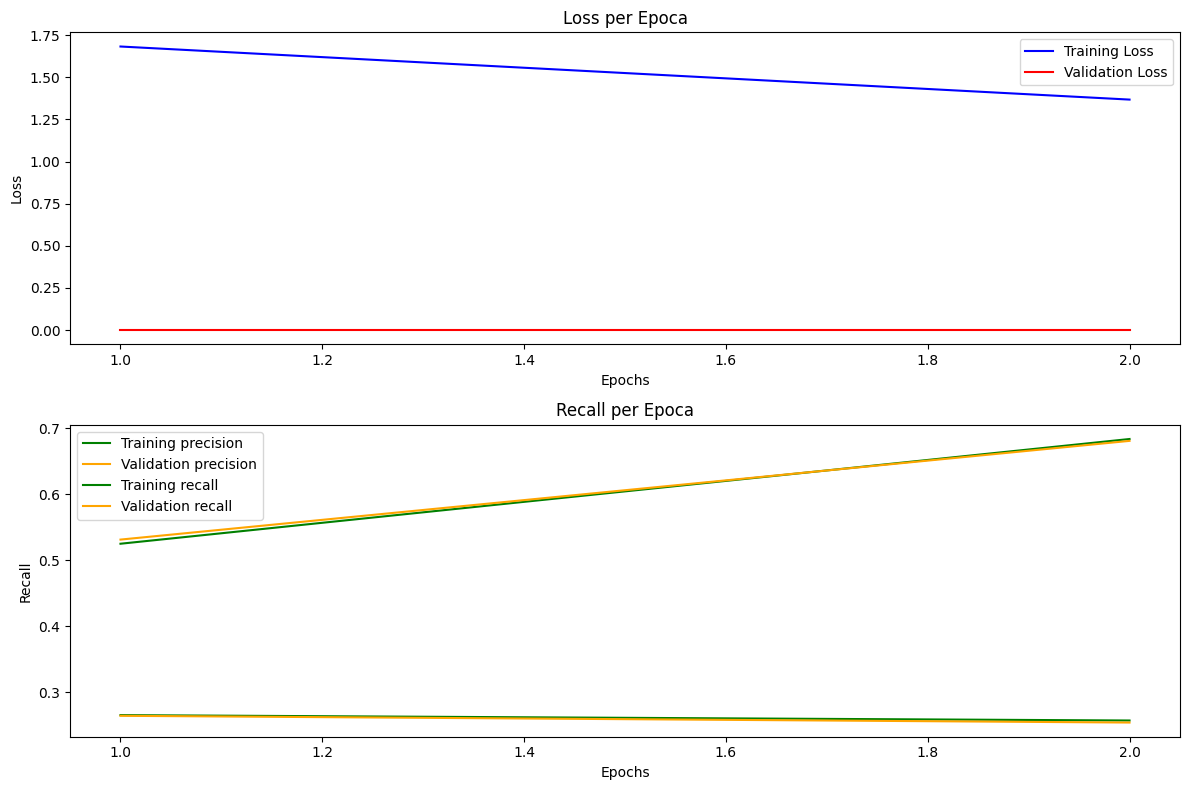

In [31]:
plot_metrics(train_losses, val_losses, train_precision, val_precision, train_recall, val_recall, num_epochs)

In [48]:
def extract_categories_from_coco_json(json_path):
    """
    Estrae i nomi delle categorie da un file JSON in formato COCO.

    Args:
        json_path (str): Path del file JSON COCO.

    Returns:
        list: Lista di nomi delle categorie ordinate.
    """
    import json  # Assicurati di importare il modulo json

    # Leggi il file JSON
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Ottieni i nomi delle categorie
    categories = [cat["name"] for cat in data.get('categories', [])]
    
    # Ordina i nomi delle categorie
    categories = sorted(categories)
    
    # Aggiungi una categoria "background" come primo elemento se non esiste
    if "background" not in categories:
        categories.insert(0, "background")
    
    return categories

# Path al file JSON COCO
json_path = "/kaggle/working/mod_COCO_annotations_new.json"

# Estrai i nomi delle categorie
categories = extract_categories_from_coco_json(json_path)

# Mostra i nomi delle categorie
print(categories)

['Aircraft', 'Building', 'Engineering Vehicle', 'Helipad', 'Maritime Vessel', 'Passenger Vehicle', 'Pylon', 'Railway Vehicle', 'Shipping Container', 'Storage Tank', 'Truck', 'background']



Inizio testing...


Testing:   0%|          | 0/101 [00:00<?, ?it/s]

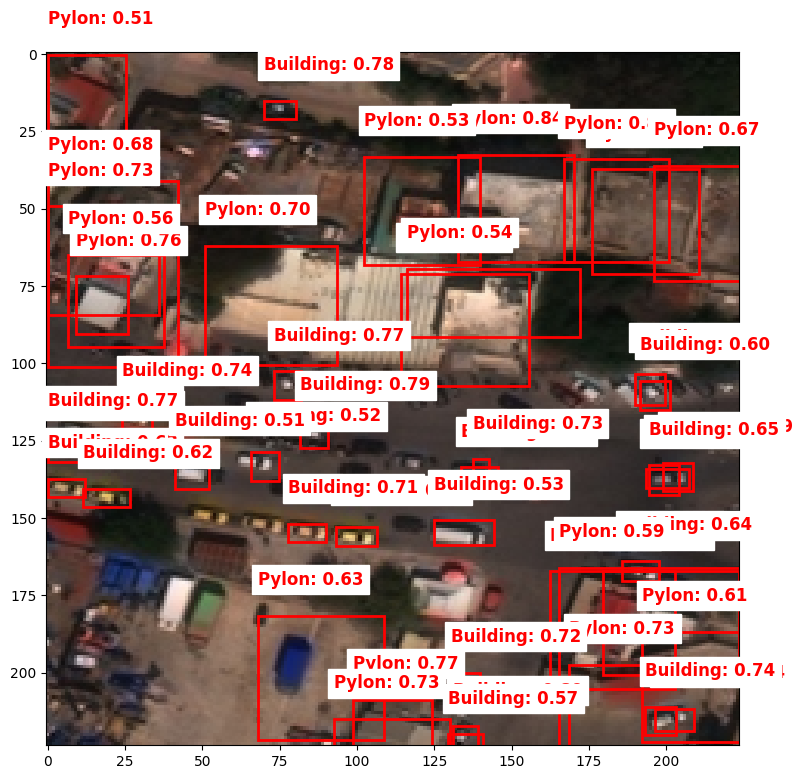

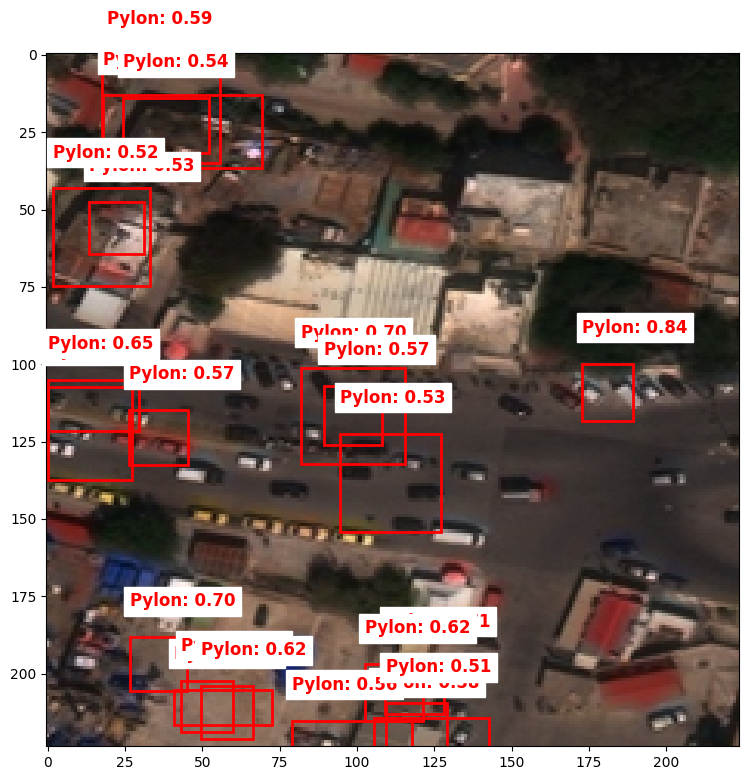

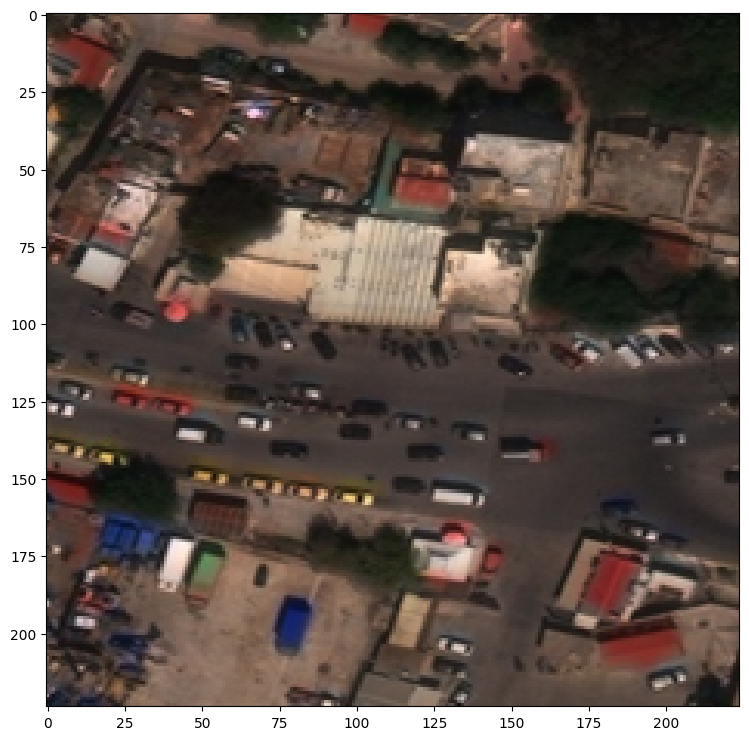

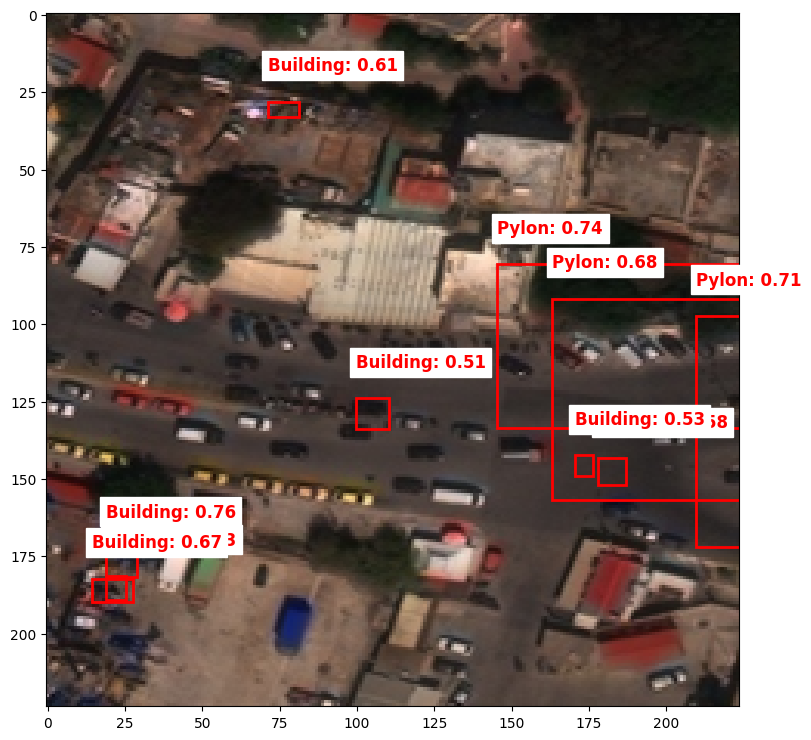

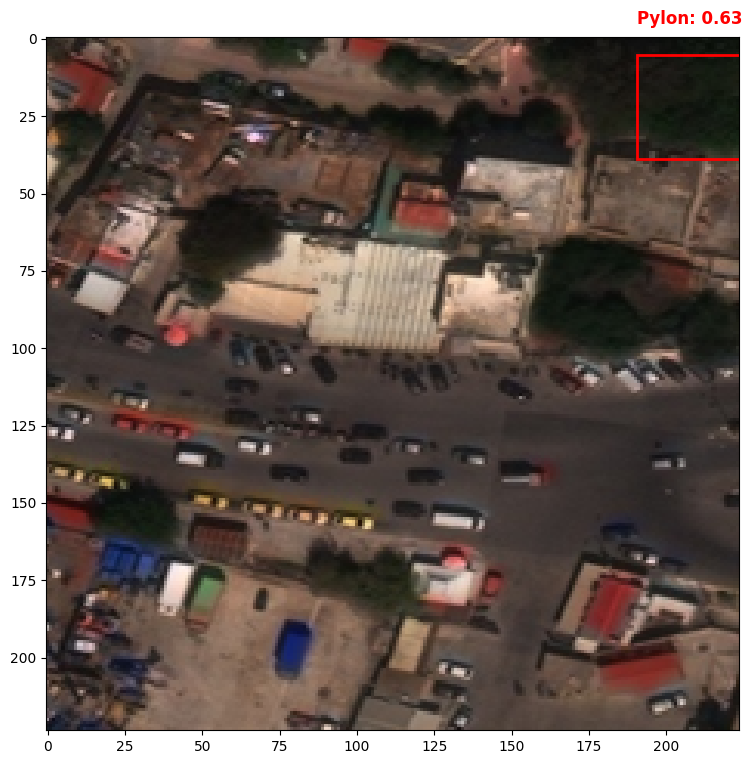


Statistiche globali del test set:
Numero totale di immagini processate: 3218
Numero totale di oggetti predetti: 295015
Numero totale di oggetti target: 69369
Numero medio di predizioni per immagine: 91.68
Numero medio di oggetti target per immagine: 21.56


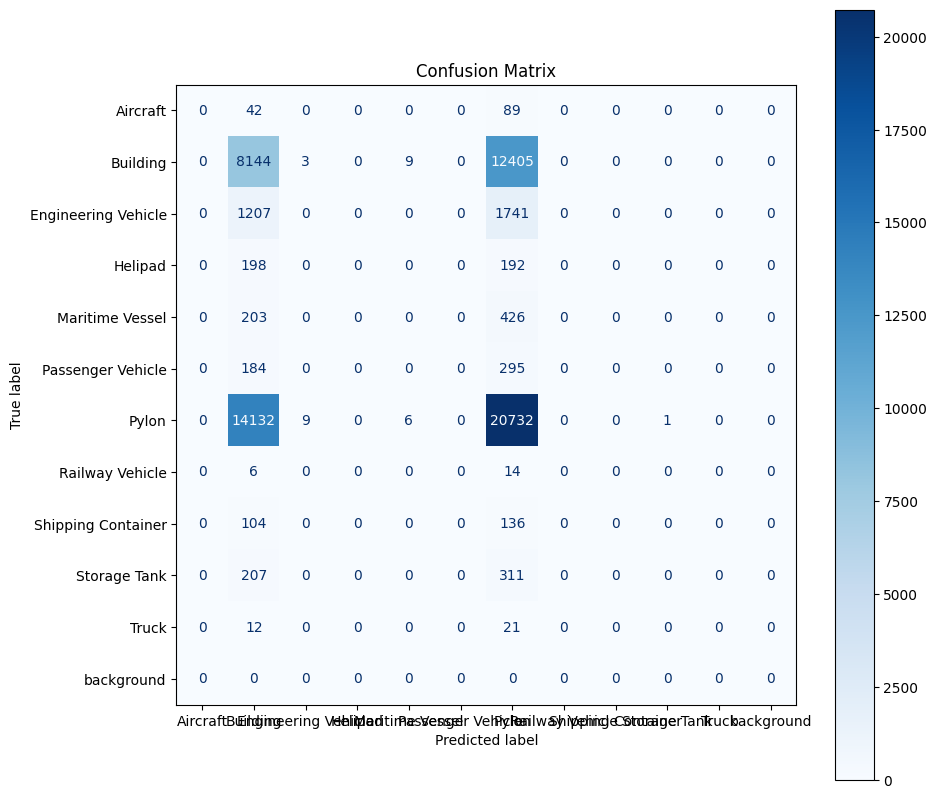

Testing completato.


In [53]:
predictions = test_model(model, test_loader, device, class_names=categories, num_classes=num_classes, num_visualizations=5)